In [184]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy.stats import kstest
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn import tree
from imblearn.over_sampling import SMOTE 
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost.sklearn import XGBClassifier
from sklearn.preprocessing import LabelEncoder
import time
plt.rcParams['font.family'] = ['Arial Unicode MS'] #正常显示中文
%matplotlib inline
warnings.filterwarnings('ignore') 
plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认字体
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题

def pd_all():
    pd.set_option('display.max_rows', None)#显示全部行
    pd.set_option('display.max_columns', None)#显示全部列

def pd_def():
    pd.set_option('display.max_rows', 10)#恢复默认显示行数
    pd.set_option('display.max_columns', 10)#恢复默认显示行数

## 数据特征解释
* _MODE  表示标准化信息众数
* _AVG 表示平均值
* _MEDI 标准化信息的中位数
* 

In [260]:
data=pd.read_csv(r'../Dataset/application_train.csv')

In [261]:
print('1样本数为：{}'.format(data.TARGET.sum()))
print('总样本数为：{}'.format(data.shape[0]))
print('少数类样本占总样本数比例：{:.5f}'.format(data.TARGET.sum()/data.shape[0]))

1样本数为：24825
总样本数为：307511
少数类样本占总样本数比例：0.08073


In [262]:
#  查看 SK_ID_CURR 是否在数据集中是唯一的
len(data['SK_ID_CURR'].unique())
data.drop('SK_ID_CURR',axis=1,inplace=True) # SK_ID_CURR 对预测无影响

307511

## 填补缺失值
特殊点：
* 数据中有许多特征明显直接相关，他们大多数为中间指标，不能直接按缺失超过0.45的方式删除
* 这些中间指标中，连续变量可以通过LR进行填补，离散变量可以通过随机森林得到补全，填补这些特征的数据使用与他们有直接相关关系的数据，进而加快填补速度及避免过多噪声

In [263]:
# # 此模块的全局变量
rate = 0.45 # 判定为严重缺失的阈值
rate = 1- rate

In [255]:
# 检查缺失数据整体情况
def examine_missing_data(df):
    missing = df.isnull().sum().sort_values(ascending=False)
    missing_percent = (100 * df.isnull().sum() / len(df)).sort_values(ascending=False)
    missing_table = pd.concat([missing, missing_percent], axis=1)
    missing_table = missing_table.rename(columns={0: '缺失值数量', 1: '缺失值占比(%)'})
    missing_table = missing_table[missing_table.iloc[:, 1] != 0]
    print("数据总共有%d个特征，其中存在缺失值的特征数为%d" % (df.shape[1], missing_table.shape[0]))
    return missing_table


missing_values = examine_missing_data(data)
pd_all()
temp = missing_values
temp
pd_def()
# temp.to_csv('../Result/缺失值情况表.csv')

数据总共有121个特征，其中存在缺失值的特征数为67


,缺失值数量,缺失值占比(%)
COMMONAREA_MEDI,214865,69.872297
COMMONAREA_AVG,214865,69.872297
COMMONAREA_MODE,214865,69.872297
NONLIVINGAPARTMENTS_MODE,213514,69.432963
NONLIVINGAPARTMENTS_MEDI,213514,69.432963
NONLIVINGAPARTMENTS_AVG,213514,69.432963
FONDKAPREMONT_MODE,210295,68.386172
LIVINGAPARTMENTS_MEDI,210199,68.354953
LIVINGAPARTMENTS_MODE,210199,68.354953
LIVINGAPARTMENTS_AVG,210199,68.354953


In [264]:
# 缺失值超过阈值的特征
cols = set(data[data.isnull()]) - set(data.dropna(thresh=data.shape[0]*rate,axis=1).columns)
print('缺失值超过{}的特征一共有{}个'.format(rate,len(cols)))

# 缺失值大部分是一些中间指标 以 AVG、MODE、MODI 为后缀，这些值中的连续变量明显有着线性关系，可以通过LR进行补全
zj_cols = data[cols].filter(regex = '_AVG|_MODE|_MEDI').columns
# data.filter(regex = '_AVG|_MODE|_MEDI').shape[1] # 47, 缺失的大部分数据是中间值
print('为中间指标的特征一共有{}个，为:\n'.format(len(zj_cols)),zj_cols)
not_zj_cols = set(cols) - set(zj_cols)
print('非中间指标的特征一共有{}个，为:\n'.format(len(not_zj_cols)),not_zj_cols)

缺失值超过0.55的特征一共有49个
为中间指标的特征一共有47个，为:
 Index(['YEARS_BUILD_MODE', 'WALLSMATERIAL_MODE', 'ELEVATORS_AVG',
       'NONLIVINGAPARTMENTS_AVG', 'LIVINGAPARTMENTS_MODE', 'APARTMENTS_AVG',
       'FLOORSMAX_AVG', 'NONLIVINGAREA_MEDI', 'FLOORSMIN_AVG',
       'YEARS_BUILD_AVG', 'YEARS_BEGINEXPLUATATION_MODE', 'ELEVATORS_MEDI',
       'APARTMENTS_MEDI', 'YEARS_BEGINEXPLUATATION_AVG', 'TOTALAREA_MODE',
       'ENTRANCES_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'COMMONAREA_MODE',
       'COMMONAREA_AVG', 'LIVINGAREA_MEDI', 'LIVINGAPARTMENTS_MEDI',
       'NONLIVINGAREA_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAREA_MODE',
       'EMERGENCYSTATE_MODE', 'ENTRANCES_AVG', 'HOUSETYPE_MODE',
       'BASEMENTAREA_MODE', 'FLOORSMIN_MODE', 'LIVINGAPARTMENTS_AVG',
       'BASEMENTAREA_AVG', 'YEARS_BUILD_MEDI', 'APARTMENTS_MODE',
       'NONLIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MODE', 'LANDAREA_MEDI',
       'FLOORSMIN_MEDI', 'LANDAREA_MODE', 'NONLIVINGAPARTMENTS_MODE',
       'BASEMENTAREA_MEDI', 'COMMONAREA_MEDI', 'FO

In [265]:
# 查看这些缺失率高于阈值的中间变量的数据类型，确定处理方案
print('这些缺失超过{}的中间指标的数据类型分布为：\n'.format(rate),data[zj_cols].dtypes.value_counts())
print('其中， object 类型特征为',data[zj_cols].select_dtypes('object').columns)
ls_cols = [ i for i in zj_cols if len(data[i].unique())<10 ] 
print('这些中间指标的离散变量为:', [ i for i in zj_cols if len(data[i].unique())<10 ])
# 这些缺失率高于阈值的中间指标中，只有 FONDKAPREMONT_MODE 为非连续变量，故先处理
# 这些变量中， object变量 和 不同值数量小于10的变量 相同，都是离散变量，所以：
ls_cols = data[zj_cols].select_dtypes('object').columns # 离散变量

这些缺失超过0.55的中间指标的数据类型分布为：
 float64    43
object      4
dtype: int64
其中， object 类型特征为 Index(['WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE', 'HOUSETYPE_MODE',
       'FONDKAPREMONT_MODE'],
      dtype='object')
这些中间指标的离散变量为: ['WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE', 'HOUSETYPE_MODE', 'FONDKAPREMONT_MODE']


In [266]:
# # 处理 FONDKAPREMONT_MODE
# # 信息增益只能用于计算离散变量
#定义计算信息熵的函数：计算Infor(D)
def infor(df):
    a = pd.value_counts(df) / len(df)
    return sum(np.log2(a) * a * (-1))

#定义计算信息增益的函数：计算g(D|A)
def g(df,str1,str2):
    e1 = df.groupby(str1).apply(lambda x:infor(x[str2]))
    p1 = pd.value_counts(df[str1]) / len(df[str1])
    #计算Infor(D|A)
    e2 = sum(e1 * p1)
    return infor(df[str2]) - e2

#定义计算信息增益率的函数：计算gr(D,A)
def gr(df,str1,str2):
    return g(df,str1,str2)/infor(df[str1])


gr(data,'TARGET','TARGET')
for i in ls_cols:
    print(i)
    print('{} 不去掉空值（空值使用"unknown"进行替换）时，信息增益率为：'.format(i))
    gr(data.fillna(value={i:'unknown'}), i, 'TARGET')

    _mode = data[i].mode()[0]
    print('{} 使用众数"{}"填充，信息增益率为：'.format(i, _mode))
    gr(data.fillna(value={i:_mode}), i, 'TARGET') 

    print('{} 去除空值时，信息增益率为：'.format(i))
    gr(data.dropna(axis = 0,subset =[i]),i,'TARGET')
    
# print('所以 FONDKAPREMONT_MODE 是一个不太重要的属性，删除')
# data.drop('FONDKAPREMONT_MODE', axis=1, inplace=True)

1.0

WALLSMATERIAL_MODE
WALLSMATERIAL_MODE 不去掉空值（空值使用"unknown"进行替换）时，信息增益率为：


0.0007852123859099351

WALLSMATERIAL_MODE 使用众数"Panel"填充，信息增益率为：


0.0002346305338449944

WALLSMATERIAL_MODE 去除空值时，信息增益率为：


0.00037983116255492293

EMERGENCYSTATE_MODE
EMERGENCYSTATE_MODE 不去掉空值（空值使用"unknown"进行替换）时，信息增益率为：


0.0012179757926267887

EMERGENCYSTATE_MODE 使用众数"No"填充，信息增益率为：


0.00024843185362254355

EMERGENCYSTATE_MODE 去除空值时，信息增益率为：


0.0008944513394649919

HOUSETYPE_MODE
HOUSETYPE_MODE 不去掉空值（空值使用"unknown"进行替换）时，信息增益率为：


0.0011184840833877421

HOUSETYPE_MODE 使用众数"block of flats"填充，信息增益率为：


0.00024106565940932044

HOUSETYPE_MODE 去除空值时，信息增益率为：


0.0007992823186348557

FONDKAPREMONT_MODE
FONDKAPREMONT_MODE 不去掉空值（空值使用"unknown"进行替换）时，信息增益率为：


0.0005408355860124634

FONDKAPREMONT_MODE 使用众数"reg oper account"填充，信息增益率为：


0.0004201841877809218

FONDKAPREMONT_MODE 去除空值时，信息增益率为：


0.00011110972824071554

In [272]:
# 【地板材质】 WALLSMATERIAL_MODE 使用'unknown'替代空值，其信息增益率0.0007852多于使用众数进行填充的信息增益率
# data 中含有WALL关键字的中间变量只有这一个
data.fillna(value={'WALLSMATERIAL_MODE':'unknown'},inplace = True)

# 【预警情况】EMERGENCYSTATE_MODE 使用众数'No'替代空值，信息增益率0.000248大于使用unknown替代（0.00122）只有 No / Yes 的情况
data.fillna(value={'EMERGENCYSTATE_MODE':'No'},inplace=True)

# 【房屋类型：连栋()/公寓楼(block of flats)/独栋(specific housing)】HOUSETYPE_MODE 使用众数 block of flats 替代空值
data.fillna(value={'HOUSETYPE_MODE':'block of flats'},inplace=True)

# 【账号情况】 FONDKAPREMONT_MODE 使用'unknown'信息增益率更高，但是差距不大：0.00054（unknown） / 0.00042（众数）
data.fillna(value={'FONDKAPREMONT_MODE':'unknown'},inplace=True)

In [279]:
# data.filter(regex='WALLSMATERIAL_MODE').columns
# data.filter(regex='EMERGENCYSTATE_MODE').columns
# data.filter(regex='HOUSETYPE').columns
# data.filter(regex='FONDKAPREMONT_MODE').columns
# # 所有离散中间值都只有众数

Index(['WALLSMATERIAL_MODE'], dtype='object')

Index(['EMERGENCYSTATE_MODE'], dtype='object')

Index(['HOUSETYPE_MODE'], dtype='object')

Index(['FONDKAPREMONT_MODE'], dtype='object')

In [283]:
# 处理上述中间指标中的连续变量
lx_cols = set(zj_cols) - set(ls_cols) # 中间值中的连续变量
print('待处理的连续中间变量：\n',lx_cols)
print('一共有{}个'.format(len(lx_cols)))

待处理的连续中间变量：
 {'YEARS_BUILD_MODE', 'ELEVATORS_AVG', 'NONLIVINGAPARTMENTS_AVG', 'LIVINGAPARTMENTS_MODE', 'APARTMENTS_AVG', 'FLOORSMAX_AVG', 'NONLIVINGAREA_MEDI', 'FLOORSMIN_AVG', 'YEARS_BUILD_AVG', 'YEARS_BEGINEXPLUATATION_MODE', 'ELEVATORS_MEDI', 'APARTMENTS_MEDI', 'YEARS_BEGINEXPLUATATION_AVG', 'TOTALAREA_MODE', 'ENTRANCES_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'COMMONAREA_MODE', 'COMMONAREA_AVG', 'LIVINGAREA_MEDI', 'LIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAREA_MODE', 'ENTRANCES_AVG', 'BASEMENTAREA_MODE', 'FLOORSMIN_MODE', 'LIVINGAPARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BUILD_MEDI', 'APARTMENTS_MODE', 'NONLIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MODE', 'LANDAREA_MEDI', 'FLOORSMIN_MEDI', 'LANDAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'BASEMENTAREA_MEDI', 'COMMONAREA_MEDI', 'LANDAREA_AVG', 'FLOORSMAX_MEDI', 'ELEVATORS_MODE', 'FLOORSMAX_MODE', 'ENTRANCES_MODE'}
一共有43个


In [289]:
set(lx_cols) - set(data.filter(regex='BUILD|FLOOR|ELEVATORS|AREA|ENTRANCES|BEGINEXPLUATATION|NONLIVINGAPARTMENT|NONLIVINGAREA|^LIVINGAPARTMENT|^LIVINGAREA|^APARTMENT'))



set()

In [288]:
data['ENTRANCES_AVG'].describe()

count    152683.000000
mean          0.149725
std           0.100049
min           0.000000
25%           0.069000
50%           0.137900
75%           0.206900
max           1.000000
Name: ENTRANCES_AVG, dtype: float64

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

regex = APARTMENTS , 匹配属性有：
 Index(['APARTMENTS_AVG', 'LIVINGAPARTMENTS_AVG', 'NONLIVINGAPARTMENTS_AVG',
       'APARTMENTS_MODE', 'LIVINGAPARTMENTS_MODE', 'NONLIVINGAPARTMENTS_MODE',
       'APARTMENTS_MEDI', 'LIVINGAPARTMENTS_MEDI', 'NONLIVINGAPARTMENTS_MEDI'],
      dtype='object')


<AxesSubplot:>

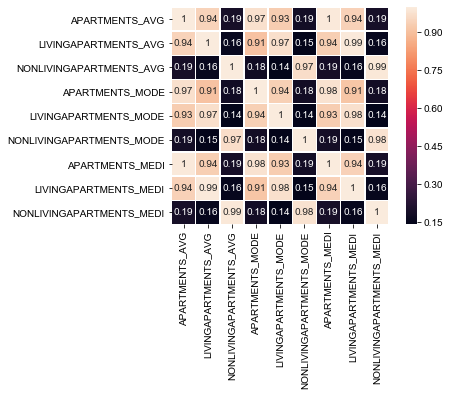

In [274]:
# 关于 APARTMENTS 的特征
plt.subplots()
matir = data.filter(regex = 'APARTMENTS').corr()
print('regex = APARTMENTS , 匹配属性有：\n',matir.columns)

sns.heatmap(matir,square=True,linewidths=.5,annot=True)
# 发现并非所有的属性都是高度相关（大于或接近0.8），故需要对 APARTMENT 匹配特性进行进一步的细分

In [275]:
# #  进行细分
# 试验含有 APARTMENTS 的变量，确保两个正则式覆盖了所有 APARTMENTS 变量，试验后发现可行
_apar = data.filter(regex='[^NON]APARTMENTS').columns
_apar
len(_apar)

_non_apar = data.filter(regex='^(NON).*APARTMENTS').columns
_non_apar
len(_non_apar)

_all_apar = data.filter(regex='APARTMENTS').columns
_all_apar
len(_all_apar)

Index(['LIVINGAPARTMENTS_AVG', 'NONLIVINGAPARTMENTS_AVG',
       'LIVINGAPARTMENTS_MODE', 'NONLIVINGAPARTMENTS_MODE',
       'LIVINGAPARTMENTS_MEDI', 'NONLIVINGAPARTMENTS_MEDI'],
      dtype='object')

6

Index(['NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAPARTMENTS_MODE',
       'NONLIVINGAPARTMENTS_MEDI'],
      dtype='object')

3

Index(['APARTMENTS_AVG', 'LIVINGAPARTMENTS_AVG', 'NONLIVINGAPARTMENTS_AVG',
       'APARTMENTS_MODE', 'LIVINGAPARTMENTS_MODE', 'NONLIVINGAPARTMENTS_MODE',
       'APARTMENTS_MEDI', 'LIVINGAPARTMENTS_MEDI', 'NONLIVINGAPARTMENTS_MEDI'],
      dtype='object')

9

In [298]:
print('一共有{}个中间变量'.format(len(data.filter(regex='_AVG|MODE|MEDI').columns))) # 47 
# 47 - 4 = 43 √

一共有47个中间变量


(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

<AxesSubplot:>

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

<AxesSubplot:>

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

<AxesSubplot:>

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

<AxesSubplot:>

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

<AxesSubplot:>

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

<AxesSubplot:>

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

<AxesSubplot:>

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

<AxesSubplot:>

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

<AxesSubplot:>

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

<AxesSubplot:>

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

<AxesSubplot:>

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

<AxesSubplot:>

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

<AxesSubplot:>

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

<AxesSubplot:>

一共有43个特征


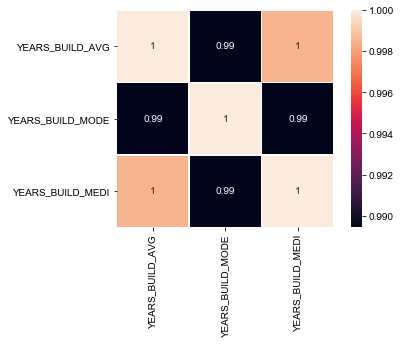

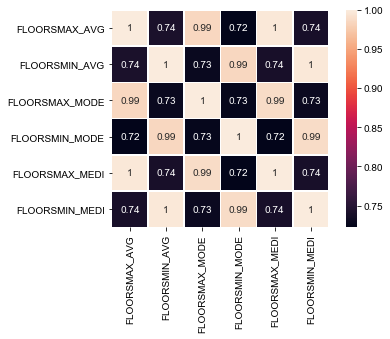

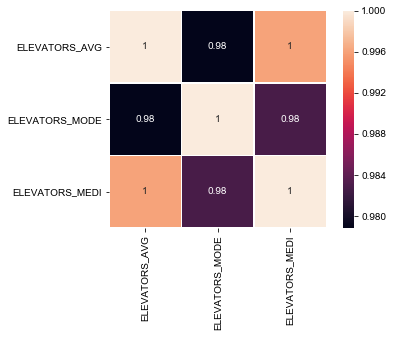

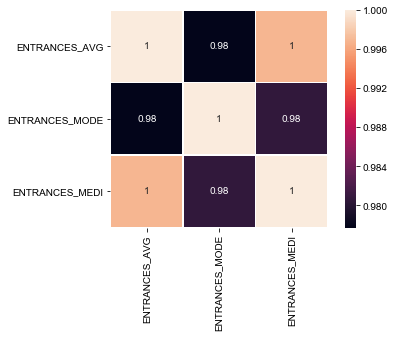

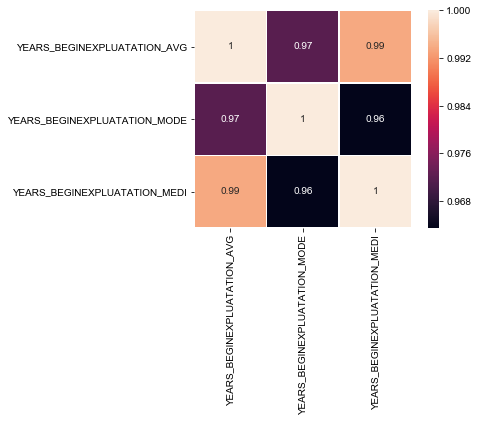

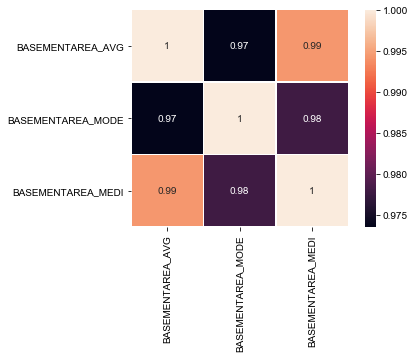

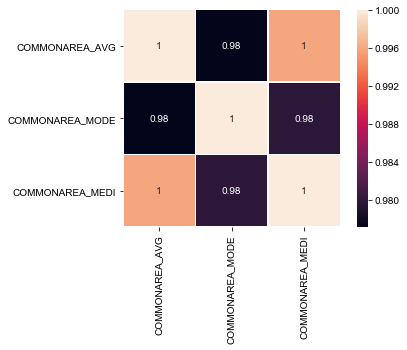

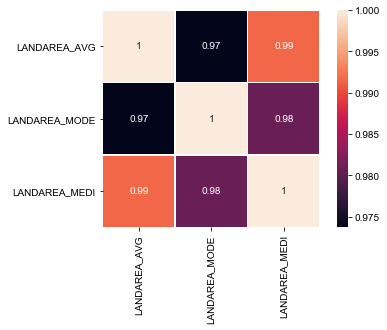

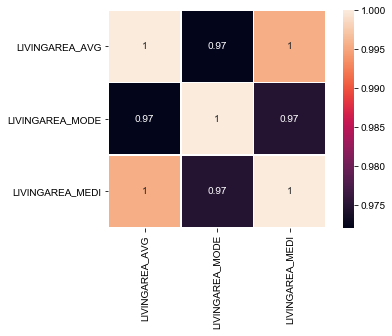

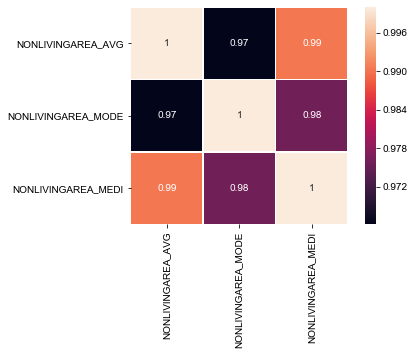

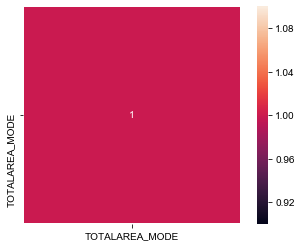

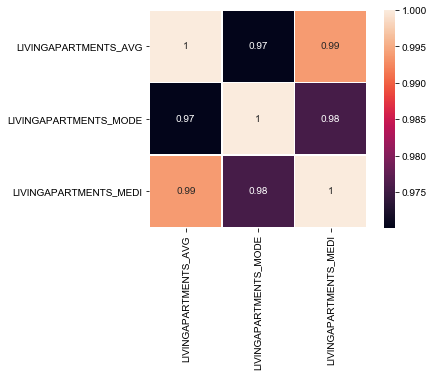

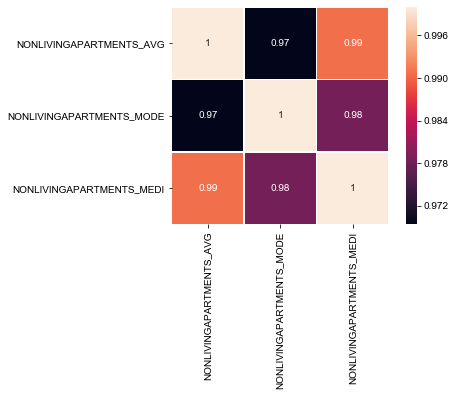

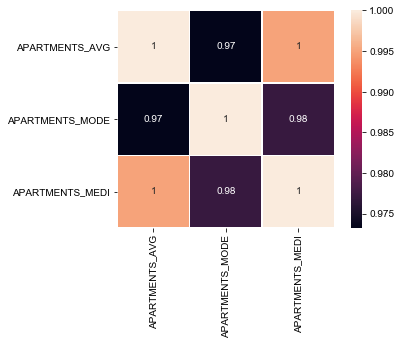

In [296]:
# 关于居住环境的特征
# _regex_str = 'BUILD|FLOOR|ELEVATORS|BASEMENTAREA|NONLIVINGAPARTMENT|NONLIVINGAREA|^LIVINGAPARTMENT|^LIVINGAREA|^APARTMENT'
_regex_str = 'BUILD|FLOOR|ELEVATORS|ENTRANCES|BEGINEXPLUATATION'
area_regex = '|BASEMENTAREA|COMMONAREA|LANDAREA|^LIVINGAREA|NONLIVINGAREA|TOTALAREA'
apar_regex = '|^LIVINGAPARTMENT|NONLIVINGAPARTMENT|^APARTMENT'
_regex_str += area_regex + apar_regex
_regex =  _regex_str.split('|') 
# 细分之后有了更好的效果
cn = 0
for rx in _regex:
    plt.subplots()
    matir = data.filter(regex = rx).corr()
    cn += matir.shape[0]
    print('regex = {}, 匹配属性有：\n'.format(rx),matir.columns) 
    
    sns.heatmap(matir,square=True,linewidths=.5,annot=True)
print('一共有{}个特征'.format(cn))

In [299]:
# 由上热图可知，所有分组内部都高度相关
# 分别计算它们的增益率，保留最大者
for rx in _regex:
    print(rx)
    _gr = '' # 记录增益率最大的特征名
    _gr_max = -1  # 保存本次遍历中最大的信息增益率
    cols = data.filter(regex = rx).columns
    for i in cols:
        _now_gr = gr(data,i,'TARGET') # 当前信息增益率
        print('{}的信息增益率为：{}'.format(i,_now_gr))
        if _gr_max < _now_gr:
            _gr = i
            _gr_max = _now_gr
    print('{}的增益率最大，为：{}'.format(_gr,_gr_max))
    new_col = cols[0]
    new_col = new_col[:new_col.rfind('_')]  # 新的列名
    # 在 data 添加新列
    data[new_col] = data[_gr]
    print('>>>>> 在 data 添加新列 "{}"'.format(new_col))
    print('>>>>> 删除冗余的旧列：',cols)
    print('\n')
    data.drop(cols,axis=1,inplace=True)

BUILD
YEARS_BUILD_AVG的信息增益率为：0.11310691213645904
YEARS_BUILD_MODE的信息增益率为：0.11304971887648763
YEARS_BUILD_MEDI的信息增益率为：0.11309719804116991
YEARS_BUILD_AVG的增益率最大，为：0.11310691213645904
>>>>> 在 data 添加新列 "YEARS_BUILD"
>>>>> 删除冗余的旧列： Index(['YEARS_BUILD_AVG', 'YEARS_BUILD_MODE', 'YEARS_BUILD_MEDI'], dtype='object')


FLOOR
FLOORSMAX_AVG的信息增益率为：0.10576358988487879
FLOORSMIN_AVG的信息增益率为：0.18190849056455244
FLOORSMAX_MODE的信息增益率为：0.12071495579552259
FLOORSMIN_MODE的信息增益率为：0.1994374261107222
FLOORSMAX_MEDI的信息增益率为：0.11376462138223599
FLOORSMIN_MEDI的信息增益率为：0.19163838306856504
FLOORSMIN_MODE的增益率最大，为：0.1994374261107222
>>>>> 在 data 添加新列 "FLOORSMAX"
>>>>> 删除冗余的旧列： Index(['FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE',
       'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI'],
      dtype='object')


ELEVATORS
ELEVATORS_AVG的信息增益率为：0.13305272639124882
ELEVATORS_MODE的信息增益率为：0.1512681345907485
ELEVATORS_MEDI的信息增益率为：0.142992632903861
ELEVATORS_MODE的增益率最大，为：0.1512681345907485
>>>>> 在 data 添加新列 "ELEVATO

In [248]:
data.filter(regex='_AVG|_MODE|_MEDI').columns

Index(['APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG',
       'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG',
       'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG',
       'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG',
       'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE',
       'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE',
       'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE',
       'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE',
       'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI',
       'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI',
       'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI',
       'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI',
       'LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI',
       'HOUSETYPE_MODE', 'TOTALAREA_MODE'

In [213]:
data.filter(regex='_MODE|_MEDI').columns
len(data.filter(regex='_MODE|_MEDI').columns)
24*2 - 6

Index(['APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE',
       'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE',
       'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE',
       'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE',
       'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI',
       'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI',
       'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI',
       'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI',
       'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI', 'HOUSETYPE_MODE',
       'TOTALAREA_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'],
      dtype='object')

32

42

In [168]:
data['EXT_SOURCE_1'].describe()

count    134133.000000
mean          0.502130
std           0.211062
min           0.014568
25%           0.334007
50%           0.505998
75%           0.675053
max           0.962693
Name: EXT_SOURCE_1, dtype: float64

In [172]:
# 计算连续变量 EXT_SOURCE_1 与TARGET的相关性

print('不填补空值，计算相关性：')
data[['EXT_SOURCE_1','TARGET']].corr()

_mean = data['EXT_SOURCE_1'].mean()
print('将空值使用平均值{}填补，相关性：'.format(_mean))
data[['EXT_SOURCE_1','TARGET']].fillna(_mean).corr()

print('将空值使用0进行填补，相关性：')
data[['EXT_SOURCE_1','TARGET']].fillna(0).corr()

print('填补后相关性反而降低，故直接删除特征 EXT_SOURCE_1')
data.drop('EXT_SOURCE_1',axis=1,inplace=True)

不填补空值，计算相关性：


,EXT_SOURCE_1,TARGET
EXT_SOURCE_1,1.000000,-0.155317
TARGET,-0.155317,1.000000


将空值使用平均值0.5021298056566625填补，相关性：


,EXT_SOURCE_1,TARGET
EXT_SOURCE_1,1.000000,-0.099152
TARGET,-0.099152,1.000000


将空值使用0进行填补，相关性：


,EXT_SOURCE_1,TARGET
EXT_SOURCE_1,1.000000,-0.064698
TARGET,-0.064698,1.000000


填补后相关性反而降低，故直接删除特征 EXT_SOURCE_1


In [173]:
# 由于 OWN_CAR_AGE 缺失超过一半，而 OWN_CAR_AGE 的缺失很可能与 OWN_CAR_AGE = 'N' 有关，后面可能会误删此数据，故先进行处理
# 对私家车信息进行处理
t = data[['OWN_CAR_AGE','FLAG_OWN_CAR']]
OWN_CAR_AGE_index = t[t['OWN_CAR_AGE'].isnull()].index
FLAG_OWN_CAR_index = t[t['FLAG_OWN_CAR']=='N'].index
OWN_CAR_AGE_len = len(OWN_CAR_AGE_index)
FLAG_OWN_CAR_len = len(FLAG_OWN_CAR_index)
print('为有车，但车龄为NaN有{}条'.format(OWN_CAR_AGE_len - FLAG_OWN_CAR_len ))
# 删除这五行数据，剩下的数据都是有车的数据车龄一定不为NaN
tt = data[data['OWN_CAR_AGE'].isnull()]
data.drop( (tt.FLAG_OWN_CAR=='Y').index, axis=0, inplace=True)
data.index = range(data.shape[0]) # 重新设置索引，避免混乱
print('无车且车龄为0的数据有{}条'.format((data[data['OWN_CAR_AGE']==0].FLAG_OWN_CAR=='N').sum()))
print('有车且车龄为0的数据有{}条'.format((data[data['OWN_CAR_AGE']==0].FLAG_OWN_CAR=='Y').sum()))
print('所以所有车龄为0的车都是购买未满月的车,车龄的单位为 月')
# 将车龄为NaN的数据改为-1
data['OWN_CAR_AGE'] = data['OWN_CAR_AGE'].fillna(-1)

# 删除 FLAG_OWN_CAR ，此时 OWN_CAR_AGE 小于0可代表 FLAG_OWN_CAR 为'N'的数据，OWN_CAR_AGE 大于等于0可代表 FLAG_OWN_CAR 为'Y'的数据
data.drop('FLAG_OWN_CAR',axis=1,inplace = True)

为有车，但车龄为NaN有5条
无车且车龄为0的数据有0条
有车且车龄为0的数据有2134条
所以所有车龄为0的车都是购买未满月的车,车龄的单位为 月


In [ ]:
# 对缺失值超过0.5的中间指标

In [33]:
# 删除缺失超过一定缺失率rate的特征，否则可能在填补时加入太多噪声
old_cols = data.columns

new_cols = data.dropna(thresh=data.shape[0]*rate,axis=1,inplace=False).columns # 待删除缺失超过50%的特征列
print('被删除的特征为：')
set(old_cols) - set(new_cols)

被删除的特征为：


{'APARTMENTS_AVG',
 'APARTMENTS_MEDI',
 'APARTMENTS_MODE',
 'BASEMENTAREA_AVG',
 'BASEMENTAREA_MEDI',
 'BASEMENTAREA_MODE',
 'COMMONAREA_AVG',
 'COMMONAREA_MEDI',
 'COMMONAREA_MODE',
 'ELEVATORS_AVG',
 'ELEVATORS_MEDI',
 'ELEVATORS_MODE',
 'ENTRANCES_AVG',
 'ENTRANCES_MEDI',
 'ENTRANCES_MODE',
 'EXT_SOURCE_1',
 'FLOORSMAX_AVG',
 'FLOORSMAX_MEDI',
 'FLOORSMAX_MODE',
 'FLOORSMIN_AVG',
 'FLOORSMIN_MEDI',
 'FLOORSMIN_MODE',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'LANDAREA_AVG',
 'LANDAREA_MEDI',
 'LANDAREA_MODE',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAPARTMENTS_MEDI',
 'LIVINGAPARTMENTS_MODE',
 'LIVINGAREA_AVG',
 'LIVINGAREA_MEDI',
 'LIVINGAREA_MODE',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAPARTMENTS_MEDI',
 'NONLIVINGAPARTMENTS_MODE',
 'NONLIVINGAREA_AVG',
 'NONLIVINGAREA_MEDI',
 'NONLIVINGAREA_MODE',
 'TOTALAREA_MODE',
 'WALLSMATERIAL_MODE',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'YEARS_BEGINEXPLUATATION_MODE',
 'YEARS_BUILD_AVG',
 'YEARS_BUILD_MEDI',
 'YEARS_BU

In [ ]:
# 其中有一些是构建的指标，查看这些指标是否有某些联系可以尽可能构建
# 删除
data.dropna(thresh=data.shape[0]*rate,axis=1,inplace=True)

In [ ]:
# 统计数据集中变量类型

In [28]:
data.dtypes.value_counts()

int64      40
float64    21
object     12
dtype: int64

## 处理离散变量

In [ ]:
# 获取所有离散变量
# ls_cols = data.select_dtypes(['int64','float']).columns # 数据集中的数值类型特

In [65]:
data.drop('FLAG_MOBIL',axis=1,inplace=True) # 只有一行为0，其他都为1，对模型贡献几乎为0

In [66]:
# 去除冗余
# 保留地区评级，去掉所在城市评级
data.drop('REGION_RATING_CLIENT_W_CITY',axis=1,inplace = True)

In [67]:
data.dtypes.value_counts()

int64      38
float64    13
object     11
dtype: int64

In [53]:
cols = data.select_dtypes(['int64','float']).columns # 数据集中的数值类型特征
cols
cols = [ i for i in cols if len(data[i].unique())>4 ] # 选取连续值
cols# 计算连续型数值特征的方差，并对方差有小到大进行排序

Index(['TARGET', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE',
       'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH',
       'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE',
       'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START',
       'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
       'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_2',
       'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
       'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3',
       'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6',
       'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9',
       'FLAG_DOCUMENT_10', 'FLA

['CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'CNT_FAM_MEMBERS',
 'HOUR_APPR_PROCESS_START',
 'EXT_SOURCE_2',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'DAYS_LAST_PHONE_CHANGE']

In [7]:
# 获取数据中所有的空值 
data_null = data.isnull().sum() 
data_null[data_null>0] 
# 删除缺失很少的行
del_rows = [i for i in data_null[data_null>0].index if data_null[i] < 100]
print('缺失值少于100个的列为',del_rows)
data.dropna(subset = del_rows, axis=0, inplace = True) # 删除缺失值缺失很少的列的行
data.index = range(data.shape[0]) # 恢复索引

AMT_ANNUITY                         12
AMT_GOODS_PRICE                    278
NAME_TYPE_SUITE                   1292
OCCUPATION_TYPE                  96391
CNT_FAM_MEMBERS                      2
EXT_SOURCE_2                       660
EXT_SOURCE_3                     60965
YEARS_BEGINEXPLUATATION_AVG     150007
FLOORSMAX_AVG                   153020
YEARS_BEGINEXPLUATATION_MODE    150007
FLOORSMAX_MODE                  153020
YEARS_BEGINEXPLUATATION_MEDI    150007
FLOORSMAX_MEDI                  153020
TOTALAREA_MODE                  148431
EMERGENCYSTATE_MODE             145755
OBS_30_CNT_SOCIAL_CIRCLE          1021
DEF_30_CNT_SOCIAL_CIRCLE          1021
OBS_60_CNT_SOCIAL_CIRCLE          1021
DEF_60_CNT_SOCIAL_CIRCLE          1021
DAYS_LAST_PHONE_CHANGE               1
AMT_REQ_CREDIT_BUREAU_HOUR       41519
AMT_REQ_CREDIT_BUREAU_DAY        41519
AMT_REQ_CREDIT_BUREAU_WEEK       41519
AMT_REQ_CREDIT_BUREAU_MON        41519
AMT_REQ_CREDIT_BUREAU_QRT        41519
AMT_REQ_CREDIT_BUREAU_YEA

缺失值少于100个的列为 ['AMT_ANNUITY', 'CNT_FAM_MEMBERS', 'DAYS_LAST_PHONE_CHANGE']


Index(['TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_EMP_PHONE',
       'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL',
       'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START',
       'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION',
       'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
       'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_2',
       'EXT_SOURCE_3', 'YEARS_BEGINEXPLUATATION_AVG', 'FLOORSMAX_AVG',
       'YEARS_BEGINEXPLU